In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers


from matplotlib import pyplot as pl
from sklearn import metrics as me
import os
import numpy as np
import itertools
import random

#test
from PIL import ImageFile
from keras.preprocessing import image

print("TF version:", tf.__version__)
print("Are GPUs available?", tf.test.is_gpu_available())

TF version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Are GPUs available? True
Using TensorFlow backend.


In [2]:
# GPU config
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
NAME = "Results/TL_MN_V1_retrained_224_True_TF02"                   ################# IMPORTANT ####################
TRAIN_PATH = r'G:/Google Drive/MASTER/TM_FlaviaPittet_2019-20/ml_data_split/train'
VALI_PATH =  r'G:/Google Drive/MASTER/TM_FlaviaPittet_2019-20/ml_data_split/validate'
TEST_PATH =  r'G:/Google Drive/MASTER/TM_FlaviaPittet_2019-20/ml_data_split/test'
CHECKPOINT_FILE=NAME+"_Model.best.hdf5"
CLASSES_NAMES = ['1', '2', '3','4','5','6','7','8','9','10']

# Image Parameters
N_CLASSES = 10 
IMG_SIZE = 224
CHANNELS = 3
COLOR = 'rgb'
CLASS_MODE = "categorical"

# Training params
batch_size = 32
epochs = 1000 #TODO do less ?
print(CHECKPOINT_FILE)

#test image problem:
ImageFile.LOAD_TRUNCATED_IMAGES = True

Results/TL_MN_V1_retrained_224_True_TF02_Model.best.hdf5


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = COLOR,
    batch_size = batch_size,
    class_mode = CLASS_MODE,
    shuffle = True,
    seed = 42
)
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size + 1

Found 1518 images belonging to 10 classes.


In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    directory = VALI_PATH,
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = COLOR,
    batch_size = batch_size,
    class_mode = CLASS_MODE,
    shuffle = False
)
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size + 1

Found 432 images belonging to 10 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory = TEST_PATH,
    target_size = (IMG_SIZE, IMG_SIZE),
    color_mode = COLOR,
    batch_size = batch_size,
    class_mode = CLASS_MODE,
    shuffle = False
)
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size + 1

Found 226 images belonging to 10 classes.


In [7]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=[IMG_SIZE, IMG_SIZE, CHANNELS])
base_model.trainable = True
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(16),            # Try 16 with less dropout (32)
    #BatchNormalization(), # Test without batch norm
    Dropout(0.5),         # Reduce Dropout def(0.7)
    Activation('relu'),
    Dense(N_CLASSES),
    Activation('softmax')
])
optimizer= optimizers.Adam(lr=0.0007)
model.compile(optimizer=optimizer, # Try changing the learning rate ! Adam(lr=0.0007)
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# checkpoint
checkpoint = ModelCheckpoint(CHECKPOINT_FILE, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)

# CALLBACKS
callbacks_list = [checkpoint, es]
#model.summary()

In [8]:
log = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 48 steps, validate for 14 steps
Epoch 1/1000
47/48 [============================>.] - ETA: 0s - loss: 2.2024 - accuracy: 0.1891
Epoch 00001: val_accuracy improved from -inf to 0.32639, saving model to Results/TL_MN_V1_retrained_224_True_TF02_Model.best.hdf5
48/48 [==============================] - 24s 496ms/step - loss: 2.2024 - accuracy: 0.1904 - val_loss: 4.4444 - val_accuracy: 0.3264
Epoch 2/1000
47/48 [============================>.] - ETA: 0s - loss: 2.0433 - accuracy: 0.2456
Epoch 00002: val_accuracy improved from 0.32639 to 0.32870, saving model to Results/TL_MN_V1_retrained_224_True_TF02_Model.best.hdf5
48/48 [==============================] - 14s 289ms/step - loss: 2.0463 - accuracy: 0.2437 - val_loss: 6.4665 - val_accuracy: 0.3287
Epoch 3/1000
47/48 [============================>.] - ETA: 0s - loss: 1.9165 - accuracy: 0.3540
Epoch 00003: val_

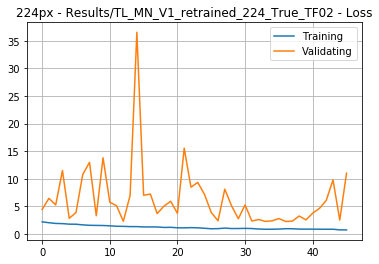

In [9]:
pl.plot(log.history['loss'], label='Training')
pl.plot(log.history['val_loss'], label='Validating')
pl.title('224px - '+NAME+' - Loss')
pl.legend()
pl.grid()
pl.savefig(NAME+'_Loss.png')

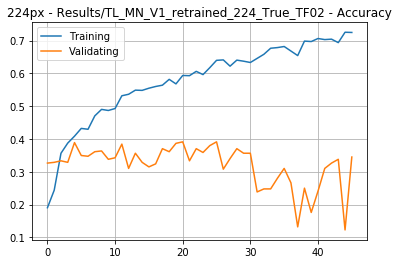

In [10]:
pl.plot(log.history['accuracy'], label='Training')
pl.plot(log.history['val_accuracy'], label='Validating')
pl.title('224px - '+NAME+' - Accuracy')
pl.legend()
pl.grid()
pl.savefig(NAME+'_Acc.png')

In [11]:
#Load best model
model.load_weights(CHECKPOINT_FILE)

In [12]:
scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
14/14 [==============================] - 3s 200ms/step - loss: 3.7434 - accuracy: 0.3912
Validating loss: 3.74341613480023
Validating accuracy: 0.3912037


In [13]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)
temp = sum(test_generator.classes == pred.argmax(axis=1))
accuracy = 100*(temp/test_generator.n)
print("Test accuracy: %.4f%%" % accuracy)

Instructions for updating:
Please use Model.predict, which supports generators.
8/8 [==============================] - 2s 269ms/step
Test accuracy: 37.6106%


In [14]:
print(me.classification_report(test_generator.classes, pred.argmax(axis=1), target_names=CLASSES_NAMES))

precision    recall  f1-score   support

           1       0.46      0.85      0.60        71
           2       0.00      0.00      0.00         7
           3       0.26      0.47      0.34        53
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00        10

    accuracy                           0.38       226
   macro avg       0.07      0.13      0.09       226
weighted avg       0.21      0.38      0.27       226



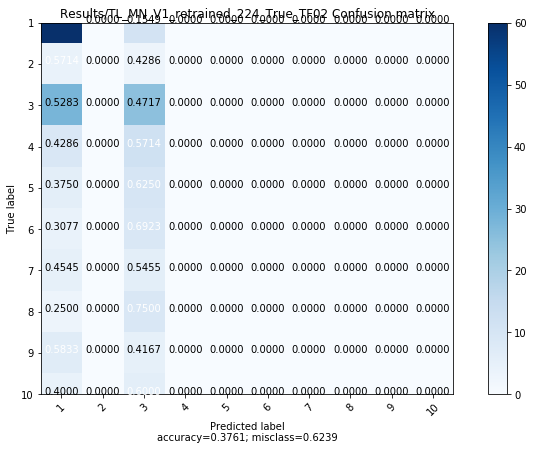

In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title=NAME+' Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = pl.get_cmap('Blues')

    pl.figure(figsize=(10, 6))
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        pl.xticks(tick_marks, target_names, rotation=45)
        pl.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            pl.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            pl.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    pl.gca().set_aspect('equal', adjustable='box')
    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    pl.savefig(NAME+'_CM.png')
    pl.show()
    
cm = me.confusion_matrix(test_generator.classes, pred.argmax(axis=1))
plot_confusion_matrix(cm, CLASSES_NAMES)

In [16]:
model.save('MN_V2_224_TF02.h5') 

In [17]:
del model
model = load_model('MN_V2_224_TF02.h5')
scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

  ...
    to  
  ['...']
14/14 [==============================] - 3s 247ms/step - loss: 3.7434 - accuracy: 0.3912
Validating loss: 3.74341613480023
Validating accuracy: 0.3912037


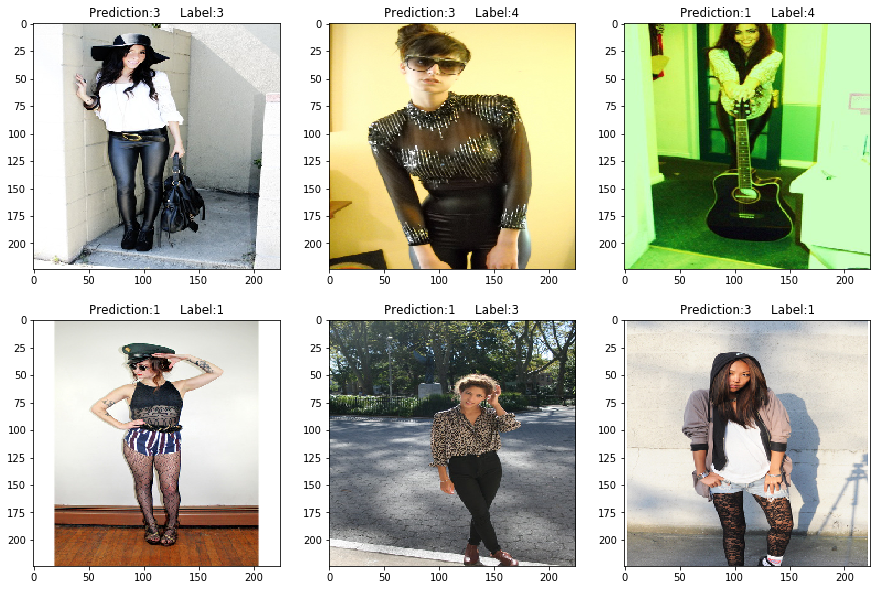

In [18]:
test_generator.reset()
test_generator.shuffle = True

#tf.keras.utils.plot_model(model, to_file=NAME+'-model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

fig, axes = pl.subplots(2, 3, figsize=(15,10))

for idx in range(0,6):
    j = idx % 3
    i = idx // 3
    x,y = test_generator.next()
    pred = model.predict(x)
    rnd = random.randint(0,31)
    image = x[rnd]
    axes[i, j].imshow(image)
    axes[i, j].title.set_text('Prediction:'+CLASSES_NAMES[pred[rnd].argmax(axis=-1)]+\
                              '     Label:'+CLASSES_NAMES[y[rnd].argmax(axis=-1)])

pl.subplots_adjust(wspace=0.2, hspace=0.2)
pl.savefig(NAME+'_examples.png')
pl.show()

In [19]:
# TODO 
testModel = load_model('MN_V2_224_TF02.h5')
# # testModel.summary()

# # testfinalGen = ImageDataGenerator(rescale=1./255)
# # testfinalGenerator = testfinalGen.flow_from_directory(
# #     file = 'G:/Google Driv/MASTER/TM_FlaviaPittet_2019-20/testing_datasets/fashion_dataset-master/fashionista/images/24_green-forever-21-jacket-white-christian-dior-shirt-blue-levis-shorts_400.jpg',
# #     target_size = (IMG_SIZE, IMG_SIZE),
# #     color_mode = COLOR,
# #     batch_size = batch_size,
# #     class_mode = CLASS_MODE,
# #     shuffle = False
# # )
# # predicting images
img_width, img_height = 224, 224
img = image.load_img("G:/Google Drive/MASTER/TM_FlaviaPittet_2019-20/testing_datasets/fashion_dataset-master/fashionista/images/24_green-forever-21-jacket-white-christian-dior-shirt-blue-levis-shorts_400.jpg", target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
testModel.predict(x)
print("FU")


AttributeError: 'numpy.ndarray' object has no attribute 'load_img'